## TASK : Build RAG how retrives data from pdf and answer user question 

In [ ]:
%pip install -qU "langchain[google-genai]" 
%pip install -qU langgraph langchain-core langchain-community langchain-text-splitters langchain-chroma langchain-google-genai beautifulsoup4
%pip install pypdf


In [ ]:
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAIEmbeddings ,ChatGoogleGenerativeAI
from langchain_community.vectorstores import Chroma


from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

#  Define LangGraph nodes and state
from langgraph.graph import StateGraph, END,START
from typing import TypedDict, Annotated, Sequence


from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.graph.message import add_messages

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


load_dotenv()



## Build llm, embedding and vectore store objects

In [ ]:

gemini_model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

## Load pdf and setup Chroma as vectore store

In [152]:
loader = PyPDFLoader("C:\\Users\\user\\LangGraph-Course\\Agents\\Stock_Market_Performance_2024.pdf")
pdf_doc = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
pdf_splited_docs = text_splitter.split_documents(pdf_doc)

chroma_db = Chroma.from_documents(
    documents=pdf_splited_docs, 
    embedding=embeddings, 
    persist_directory="data2", 
    collection_name="lc_chroma_demo2"
)



## define the LangGraph states

In [153]:
class GraphState(TypedDict):
    question: str
    messages: Annotated[Sequence[BaseMessage], add_messages]
    answer: str
    docs: Sequence[str]
    aggregated_text: str

## Define the prompt

In [154]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer {question} to the best of your ability according to {aggregated_text}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

## Define Retriver node 

In [155]:
def retrieve_node(state: GraphState) -> GraphState:
    question = state["question"]
    retriever = chroma_db.as_retriever()
    docs = retriever.invoke(question)
    return {"docs": [doc.page_content for doc in docs]}



## define aggregate doc node

In [156]:
def aggregate_docs_node(state: GraphState) -> GraphState:
    """
    Aggregates retrieved documents into a single text block for the LLM.
    """
    docs = state.get("docs", [])
    print(f'Retrieved {len(docs)} documents for aggregation.')
    # Join all chunks into one string with separators
    aggregated_text = "\n\n".join(docs)
    
    # Return as a new state for the next node
    return {"aggregated_text": aggregated_text}

## Define LLM node

In [157]:
def llm_node(state: GraphState) -> GraphState:
  print(f'*****state before llm_node: {state}')
  prompt = prompt_template.invoke(state)
  print(f'Me : {prompt}')
  response = gemini_model.invoke(prompt)
  return {"answer": response, "messages": state["messages"]}



## Build the workflow graph

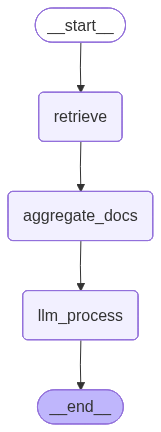

In [158]:

workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("llm_process", llm_node)
workflow.add_node("aggregate_docs", aggregate_docs_node)

workflow.add_edge(START,"retrieve")
workflow.add_edge("retrieve", "aggregate_docs")
workflow.add_edge("aggregate_docs", "llm_process")
workflow.add_edge("llm_process", END)

app = workflow.compile()
app



# 5. Query the system


In [161]:
query= "which year this article is checking the performance of stock market?"
result = app.invoke({"messages": [HumanMessage(content=query)], "question": query})
print(result["answer"])

Retrieved 4 documents for aggregation.
*****state before llm_node: {'question': 'which year this article is checking the performance of stock market?', 'messages': [HumanMessage(content='which year this article is checking the performance of stock market?', additional_kwargs={}, response_metadata={}, id='1e591057-c6f6-458a-be30-7ac87dbf04b5')], 'docs': ['Stock Market Performance in 2024\nU.S. Market Overview\nThe year 2024 was a remarkably strong one for equities, with the U.S. stock market extending the\nrobust gains seen in the prior year. The benchmark S&P 500 index delivered roughly a 25% total\nreturn for 2024 (around +23% in price terms)\n. This marked the second consecutive year of over 20% returns for the S&P 500 - a feat not\nobserved since the late 1990s\n. The tech-heavy Nasdaq Composite outpaced the broader market, jumping nearly 29% for the year\n. In contrast, smaller-cap stocks had more modest performance: the S&P 500 Equal-Weight index\nand the Russell 2000 (small-cap b